# Reproduction for "Driver Identiﬁcation Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network"

Authors:  
Daniel Cisneros Acevedo (4657349)  
Emre Ünlü (5404290)  
Stijn Waltmann (4548035) 

The goal of this blog is to reproduce the paper [Driver Identification Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network](https://arxiv.org/abs/1911.08030). This paper uses vehicle telematics data (OBD-II) with machine learning tools to classify the driving style of a driver. The proposed model is a Long-Short Term Memory (LSTMs), this is an RNN architectures variant. For this reproduction, our group is assigned to reproduce Figures 9 & 10. These figures compare the accuracy of LTSMs against FCNN, Decision tree, and Random Forest models by inducing increasing levels of noise on the test data. We have chosen to do a mix of reproducing a small portion of the code and using some of the criteria given on Brightspace.

<figure>
  <img src="Figure9.png" ref="Figure 9" width="400">
  <img src="Figure10.png" ref="Figure 9" width="480">
  <figcaption>Figure 9 & 10</figcaption>
</figure>

## Inspecting the code

First look at the code it seems a bit messy, with multiple imports and multiple functions defined throughout the code. When running the code we seem to have trouble with X_test_5. Also, the author of the paper mentioned the code could have some issues because it was developed in a different setting.

We have copied several functions from the author's main code to our code main_functions.py and added docstrings for further clarification

## Data

There are three datasets from which one is of importance to us. That is the security driving dataset, collected by KIA Motors Corporation car in an uncontrolled environment. This is the only relevant dataset for this reproduction because figures 9 & 10 only contain these data points.

In [3]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

# import functions from main.py
from main_functions import *

The data from the Security Driving Dataset is shown below below. There are 94380 datapoints and 54 columns. The "Class" represents the driver_id.
It's not a bad idea to look at the data distribution of the classes as class imbalance may affect model performance. Note, there are a total of 10 classes, or drivers in this case.

In [4]:
# read data
df = pd.read_csv('./Data/korea_vehicledata.csv')
df

,Time(s),Class,PathOrder,Fuel_consumption,Accelerator_Pedal_value,Throttle_position_signal,Short_Term_Fuel_Trim_Bank1,Intake_air_pressure,Filtered_Accelerator_Pedal_value,Absolute_throttle_position,...,Converter_clutch,Gear_Selection,Vehicle_speed,Acceleration_speed_-_Longitudinal,Indication_of_brake_switch_ON/OFF,Master_cylinder_pressure,Calculated_road_gradient,Acceleration_speed_-_Lateral,Steering_wheel_speed,Steering_wheel_angle
0,1,A,1,268.8,0.0,5.2,0.0,33,0,13.3,...,0,0,0,-8.5,1,325.5,0.0,-8.8,0,-3.4
1,2,A,1,243.2,0.0,6.1,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
2,3,A,1,217.6,0.0,5.2,0.0,41,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
3,4,A,1,204.8,0.0,4.7,0.0,38,0,13.3,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
4,5,A,1,217.6,0.0,5.7,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94375,2564,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,-0.2,2,2.3,0.0,0.0,0,-13.2
94376,2565,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,0.1,2,8.7,0.0,-0.1,0,-13.0
94377,2566,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,0,0,-0.2,2,12.6,0.0,0.0,0,-13.2
94378,2567,D,2,332.8,0.0,5.7,6.3,0,0,14.1,...,0,0,0,-0.2,2,13.0,0.0,0.0,0,-13.3


Class D and B have the highest number of datapoints


Text(0.5, 0, 'Classes')

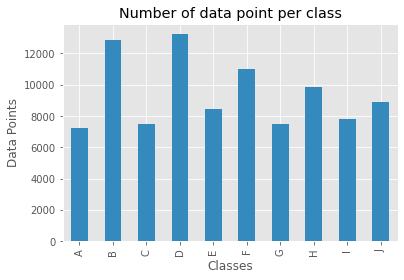

In [8]:
# data distribution per class

print('Class D and B have the highest number of datapoints')

df['Class'].value_counts().sort_index().plot(kind='bar', title='Number of data point per class',color='C1')
plt.ylabel('Data Points')
plt.xlabel('Classes')

## Model Architecture

The architecture of the deep LTSM model is a two hidden layer network with 160 neurons in the first hidden layer and 200 neurons in the second hidden layer. 

Fortunately, the authors provided us with their model which we can use as inspiration to start off our search!

The model .config() can be commented out for more information on the exact settings. For example, we can find out which dropout rate the authors used.

In [9]:
author_model = load_model('Model_clean_binary_cross_ICTAI_vehicle2_1')
author_model.summary()

2022-03-31 10:12:19.997909: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 160)         116480    
                                                                 
 batch_normalization_3 (Batc  (None, None, 160)        640       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, None, 160)         0         
                                                                 
 lstm_4 (LSTM)               (None, 120)               134880    
                                                                 
 batch_normalization_4 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 120)               0

In [12]:
# comment out this line to obtain model setup
# author_model.get_config()

## Approach

Right now, the playfield and overall context of the data is pretty clear. It's time to start building models and fitting it to the data. 

The original idea was to use the criteria mentioned on Brightspace however, the code didn't fully run therefore we created our own model so we could run it. Next to this, we will also apply a hyperparameter check and ablation study.

## Reproducing fig 9 push